# Unfolded SDK Machine Learning Demo (LA Bike Share)

[![open_in_colab][colab_badge]][colab_notebook_link]
[![open_in_binder][binder_badge]][binder_notebook_link]

[colab_badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab_notebook_link]: https://colab.research.google.com/github/UnfoldedInc/examples/blob/master/notebooks/12%20-%20Pytorch%20Trip%20Duration.ipynb
[binder_badge]: https://mybinder.org/badge_logo.svg
[binder_notebook_link]: https://mybinder.org/v2/gh/UnfoldedInc/examples/master?urlpath=lab/tree/notebooks/12%20-%20Pytorch%20Trip%20Duration.ipynb

For this demo [data](https://www.kaggle.com/cityofLA/los-angeles-metro-bike-share-trip-data) was taken from Kaggle. It contains information about bike share trips throughout a year in Los Angeles. The task is to predict bike trip duration as it may be useful to know when a bike will be returned. Prediction is made using starting share point location, time and some other info.


## Dependencies

This notebook uses the following dependencies:

- `xarray`
- `dask`
- `netCDF4`
- `bottleneck`
- `tqdm`
- `dask-ml`
- `pandas`
- `seaborn`
- `matplotlib`
- `scikit-learn`
- `category_encoders`
- `torch`
- `missingno`
- `unfolded.map-sdk`
- `unfolded.data-sdk`

If running this notebook in Binder, these dependencies should already be installed. If running in Colab, the next cell will install these dependencies. In another environment, you'll need to make sure these dependencies are available by running the following `pip` command in a shell.

```bash
pip install xarray dask netCDF4 bottleneck tqdm dask-ml pandas seaborn matplotlib scikit-learn category_encoders torch missingno unfolded.map-sdk unfolded.data-sdk
```

This notebook was originally tested with the following package versions, but likely works with a broad range of versions:

- xarray==0.19.0 
- dask==2021.09.1 
- netCDF4==1.5.7 
- bottleneck==1.3.2 
- tqdm==4.62.3 
- dask-ml==1.9.0 
- pandas==1.3.3 
- seaborn==0.11.2 
- matplotlib==3.4.3 
- scikit-learn==1.0 
- category_encoders==2.2.2
- torch==1.9.1 
- missingno==0.5.0 
- unfolded.map-sdk==0.5.0
- unfolded.data-sdk==0.5.0

In [ ]:
# If in Colab, install this notebook's required dependencies
import sys
if "google.colab" in sys.modules:
    !pip install 'unfolded.map_sdk>=0.6.0' xarray dask netCDF4 bottleneck tqdm dask-ml pandas seaborn matplotlib scikit-learn category_encoders torch missingno unfolded.data-sdk

## Imports

In [1]:
import time
import math
import random
import os
import requests
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
from tqdm import tqdm
import category_encoders as ce
import missingno as msno
from uuid import uuid4
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from unfolded.map_sdk import UnfoldedMap

## Load Dataset

Load <code>.nc</code> dataset

In [2]:
def load_data(url, path):
    if os.path.isfile(path):
        pass
    else:
        response = requests.get(url, stream=True)
        total_size_in_bytes = int(response.headers.get("content-length", 0))
        block_size = 1048576  # 1 Megabyte
        progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
        with open(path, "wb") as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

        progress_bar.close()


dataset_url = "https://actionengine-public.s3.us-east-2.amazonaws.com/metro-bike-share-trip-data.nc"
dataset_path = "metro-bike-share-trip-data-downloaded.nc"
load_data(dataset_url, dataset_path)

## Data Clean-up


Open dataset and convert it to dask format

In [3]:
ds = xr.open_dataset("metro-bike-share-trip-data-downloaded.nc", chunks={"Start Time": 135000})
ddf = ds.to_dask_dataframe(set_index=True)

ddf.head()

,Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station Latitude,Ending Station Longitude,Plan Duration,Trip Route Category,Passholder Type,Neighborhood Councils (Certified),Council Districts,Zip Codes,Precinct Boundaries,Census Tracts
index,,,,,,,,,,,,,,,
0,15060,2017-01-19T17:05:00.000,3031.0,34.044701,-118.252441,NaN,NaN,0.0,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN
1,77160,2016-10-09T14:37:00.000,NaN,NaN,NaN,NaN,NaN,30.0,One Way,Monthly Pass,NaN,NaN,NaN,NaN,NaN
2,86400,2017-02-18T10:15:00.000,3026.0,34.063179,-118.245880,NaN,NaN,0.0,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN
3,18840,2017-02-27T12:26:00.000,3023.0,34.050911,-118.240967,NaN,NaN,0.0,One Way,Walk-up,NaN,NaN,NaN,NaN,NaN
4,86400,2017-02-27T20:26:00.000,3008.0,34.046612,-118.262733,NaN,NaN,365.0,One Way,Flex Pass,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Dataset has ", ddf.shape[0].compute(), " rows")

Dataset has  132427  rows


Look at how many NaNs are in columns

<AxesSubplot:>

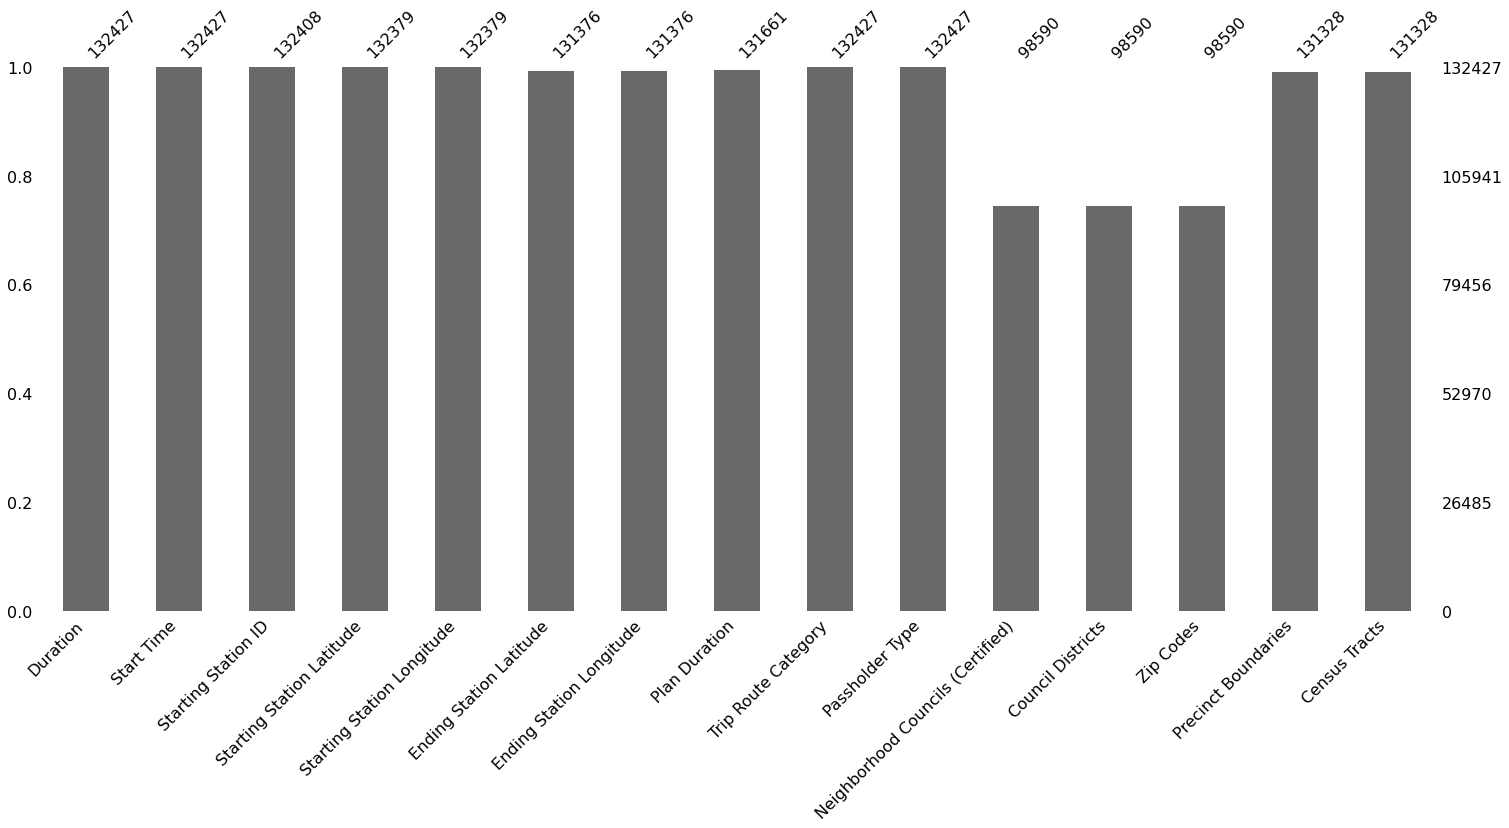

In [5]:
msno.bar(ddf.compute())

Delete raws without necessary information: starting or ending point latutude and longitude, start time, etc

In [6]:
ddf = ddf.dropna(
    subset=[
        "Starting Station ID",
        "Starting Station Latitude",
        "Starting Station Longitude",
        "Ending Station Latitude",
        "Ending Station Longitude",
        "Start Time",
        "Precinct Boundaries",
        "Census Tracts",
        "Plan Duration",
    ]
)

Delete rows with 0 in <b>Starting Station Latitude</b> column and fill all NaNs with zeroes.

In [7]:
ddf = ddf[(ddf["Starting Station Latitude"] != 0)]
ddf = ddf.fillna(0)

In [8]:
print("Dataset has ", ddf.shape[0].compute(), " rows")

Dataset has  130659  rows


### Trip Duration Histogram

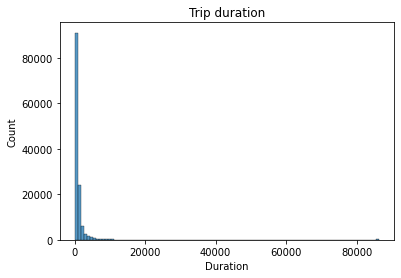

In [9]:
hist = sns.histplot(data=ddf["Duration"], bins=100)
hist.set(xlabel="Duration")
hist.set_title("Trip duration")
plt.show()

Remove outliers from <b>Duration</b> column. The IQR (Interquartile Range) method is used. The lower border is Q1-1.5\*IQR and the upper border is Q3+1.5\*IQR <br>
[To read more](https://en.wikipedia.org/wiki/Interquartile_range)

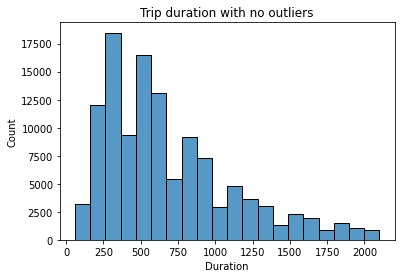

In [10]:
def outlier_borders(data):
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower, upper


lower, upper = outlier_borders(ddf["Duration"])
no_outliers = [x for x in ddf["Duration"] if x > lower and x < upper]
ddf = ddf[(ddf["Duration"] < upper)]
hist = sns.histplot(data=no_outliers, bins=20)
hist.set(xlabel="Duration")
hist.set_title("Trip duration with no outliers")
plt.show()

Manually remove two outlier records (to not remove useful dots)

In [11]:
ddf = ddf[(ddf["Starting Station Longitude"] > -118.3)]

print("Dataset has ", ddf.shape[0].compute(), " rows")

Dataset has  118603  rows


## Visualization

### Starting Points Map

Points on a map represent starting stations location. The lighter a point, the more trips started from it.

In [ ]:
stations_map = UnfoldedMap()
stations_map

In [37]:
# TODO: make this plot open in 3D automatically and add height to hexagons

ddf["Starting Station Latitude"] = ddf["Starting Station Latitude"].compute().round(6)
ddf["Starting Station Longitude"] = ddf["Starting Station Longitude"].compute().round(6)
ddf["Ending Station Latitude"] = ddf["Ending Station Latitude"].compute().round(6)
ddf["Ending Station Longitude"] = ddf["Ending Station Longitude"].compute().round(6)

start_stations = ddf[
    ["Starting Station Latitude", "Starting Station Longitude"]
].compute()

start_stations = start_stations.groupby(
    ["Starting Station Latitude", "Starting Station Longitude"]
).size()
start_stations = pd.DataFrame(start_stations.reset_index())
start_stations.rename(columns={0: "count"}, inplace=True)

stations_dataset_id = uuid4()

stations_map.add_dataset(
    {"uuid": stations_dataset_id, "label": "Stations dataset", "data": start_stations},
    auto_create_layers=False,
)

stations_map.add_layer(
    {
        "id": "Starting points",
        "type": "hexagon",
        "config": {
            "label": "Starting points",
            "data_id": stations_dataset_id,
            "columns": {
                "lat": "Starting Station Latitude",
                "lng": "Starting Station Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "count", "type": "int"},
            "visConfig": {"worldUnitSize": 0.1,},
            "visualChannels": {
            "colorScale": "quantile",
            "sizeScale": "linear"
          }
        },
        
    }
)


stations_map.set_view_state({"longitude": -118.25, "latitude": 34.04, "zoom": 12})

UnfoldedMap()

### Routes Map

Arcs on a map connect starting and ending point of a trip. The lighter an arc, the more trips are between points it connects.

In [ ]:
routes_map = UnfoldedMap()
routes_map

In [13]:
routes = ddf[
    [
        "Starting Station Latitude",
        "Starting Station Longitude",
        "Ending Station Latitude",
        "Ending Station Longitude",
    ]
].compute()
routes = routes.groupby(
    [
        "Starting Station Latitude",
        "Starting Station Longitude",
        "Ending Station Latitude",
        "Ending Station Longitude",
    ]
).size()
routes = pd.DataFrame(routes.reset_index())
routes.rename(columns={0: "count"}, inplace=True)

routes_dataset_id = uuid4()

routes_map.add_dataset(
    {"uuid": routes_dataset_id, "label": "Routes dataset", "data": routes},
    auto_create_layers=False,
)

routes_map.add_layer(
    {
        "id": "Routes",
        "type": "arc",
        "config": {
            "label": "Routes",
            "data_id": routes_dataset_id,
            "columns": {
                "lat0": "Starting Station Latitude",
                "lng0": "Starting Station Longitude",
                "lat1": "Ending Station Latitude",
                "lng1": "Ending Station Longitude",
            },
            "is_visible": True,
            "visConfig": {"opacity": 0.8, "thickness": 0.3},
            "color_scale": "quantile",
            "color_field": {"name": "count", "type": "int"},
            "vis_config": {
                "opacity": 0.8,
                "thickness": 0.3,
                "colorRange": {
                    "colors": [
                        "#5A1846",
                        "#900C3F",
                        "#C70039",
                        "#E3611C",
                        "#F1920E",
                        "#FFC300",
                    ],
                },
                "target_color": "count",
            },
        },
    }
)

routes_map.set_view_state({"longitude": -118.25, "latitude": 34.04, "zoom": 12})

UnfoldedMap()

### Visualization of Category Data

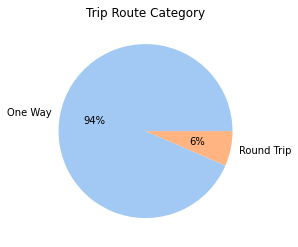

In [14]:
trip_category_stats = ddf["Trip Route Category"].value_counts().compute()

colors = sns.color_palette("pastel")[0:5]
plt.title("Trip Route Category")
plt.pie(
    trip_category_stats.values,
    labels=trip_category_stats.index,
    colors=colors,
    autopct="%.0f%%",
)
plt.show()

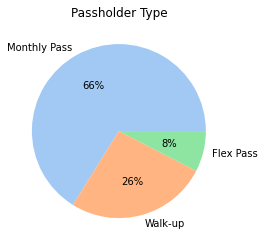

In [15]:
plan_category_stats = ddf["Passholder Type"].value_counts().compute()

colors = sns.color_palette("pastel")[0:5]
plt.title("Passholder Type")
plt.pie(
    plan_category_stats.values,
    labels=plan_category_stats.index,
    colors=colors,
    autopct="%.0f%%",
)
plt.show()

As shown in figures above, most people prefer to take one way trips and get a monthly pass.

## Preprocessing

### Preprocess Datetime Features

All data has to be turned into numerical form, so datetime feature column <b>Start Time</b> is decomposed into several feature columns (<b>Year</b>, <b>Month</b>, etc)

In [16]:
ddf["Start Time"] = pd.to_datetime(ddf["Start Time"].compute())


def extract_time_features(timestamp):
    return [
        timestamp.year,
        timestamp.month,
        timestamp.day,
        timestamp.hour,
        timestamp.minute,
    ]


ddf_to_concat = ddf.compute().reset_index(drop=True)
time_features_ddf = ddf_to_concat["Start Time"].apply(extract_time_features)
time_features_df = pd.DataFrame(
    time_features_ddf.tolist(), columns=["Year", "Month", "Day", "Hour", "Minute"]
)
df_with_time_features = pd.concat([ddf_to_concat, time_features_df], axis=1)
df_with_time_features = df_with_time_features.drop(columns=["Start Time"])

df_with_time_features

,Duration,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station Latitude,Ending Station Longitude,Plan Duration,Trip Route Category,Passholder Type,Neighborhood Councils (Certified),Council Districts,Zip Codes,Precinct Boundaries,Census Tracts,Year,Month,Day,Hour,Minute
0,480,3082.0,34.046520,-118.237411,34.039188,-118.232529,0.0,One Way,Walk-up,0.0,0.0,0.0,1287.0,533.0,2017,1,13,21,32
1,540,3029.0,34.048851,-118.246422,34.046520,-118.237411,30.0,One Way,Monthly Pass,0.0,0.0,0.0,466.0,533.0,2017,2,24,23,13
2,840,3022.0,34.046070,-118.233093,34.048550,-118.259048,30.0,One Way,Monthly Pass,0.0,0.0,0.0,1050.0,546.0,2017,2,23,7,34
3,420,3059.0,34.037949,-118.256271,34.046822,-118.248352,30.0,One Way,Monthly Pass,0.0,0.0,0.0,1502.0,542.0,2017,1,5,12,4
4,840,3035.0,34.048401,-118.260948,34.053570,-118.266357,0.0,One Way,Walk-up,0.0,0.0,0.0,1047.0,564.0,2017,1,30,20,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118598,660,3005.0,34.048550,-118.259050,34.052898,-118.241560,0.0,One Way,Walk-up,76.0,9.0,23078.0,1502.0,543.0,2016,8,17,10,54
118599,1080,3027.0,34.049980,-118.247160,34.035679,-118.270810,30.0,One Way,Monthly Pass,76.0,9.0,23074.0,660.0,694.0,2016,8,8,7,18
118600,1500,3014.0,34.056610,-118.237210,34.031052,-118.267090,30.0,One Way,Monthly Pass,28.0,9.0,22728.0,660.0,694.0,2016,7,30,15,52
118601,780,3036.0,34.039188,-118.232530,34.044159,-118.251580,365.0,One Way,Flex Pass,28.0,9.0,23074.0,527.0,542.0,2016,8,12,9,17


### Split dataset on Train, Validation and Test Parts

In [17]:
y = df_with_time_features["Duration"]
X = df_with_time_features.drop(
    columns=["Duration", "Ending Station Latitude", "Ending Station Longitude"]
)

X_cut, X_test, y_cut, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_cut, y_cut, test_size=0.1, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Apply Count Encoder to Categorical Features

As already mentioned, all data has to be turned into numerical form, including categorical variables. To do this, count encoding method was chosen. It replaces each categorical value in a column with the number proportional to the number of times this value appears in this column. <br>
[To read more](http://contrib.scikit-learn.org/category_encoders/count.html)

In [18]:
columns_for_count_encoder = [
    "Passholder Type",
    "Trip Route Category",
    "Starting Station ID",
    "Plan Duration",
    "Neighborhood Councils (Certified)",
    "Council Districts",
    "Zip Codes",
    "Precinct Boundaries",
    "Census Tracts",
]

count_encoder = ce.CountEncoder(
    cols=columns_for_count_encoder, return_df=True, normalize=True
)

count_encoder = count_encoder.fit(X_train)

X_train = count_encoder.transform(X_train)
X_val = count_encoder.transform(X_val)
X_test = count_encoder.transform(X_test)

X_train

C:\ProgramData\Anaconda3\envs\unf_env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Plan Duration,Trip Route Category,Passholder Type,Neighborhood Councils (Certified),Council Districts,Zip Codes,Precinct Boundaries,Census Tracts,Year,Month,Day,Hour,Minute
0,0.037703,34.050880,-118.248250,0.261724,0.935191,0.261724,0.551209,0.694765,0.138601,0.086429,0.153372,2016,8,12,21,21
1,0.025638,34.048401,-118.260948,0.662111,0.935191,0.662111,0.251450,0.251450,0.251450,0.177865,0.117387,2017,2,9,14,27
2,0.029708,34.049301,-118.238808,0.662111,0.935191,0.662111,0.194666,0.694765,0.225811,0.160253,0.076509,2016,10,3,16,28
3,0.015687,34.046612,-118.262730,0.662111,0.935191,0.662111,0.551209,0.694765,0.106936,0.057762,0.095225,2016,8,29,12,24
4,0.015489,34.052898,-118.241560,0.662111,0.064809,0.662111,0.551209,0.694765,0.225811,0.160253,0.076509,2016,8,8,14,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96062,0.015687,34.046612,-118.262733,0.662111,0.935191,0.662111,0.251450,0.251450,0.251450,0.010274,0.225249,2017,3,23,8,18
96063,0.034986,34.056610,-118.237213,0.662111,0.064809,0.662111,0.251450,0.251450,0.251450,0.041887,0.041887,2017,2,1,17,42
96064,0.029708,34.049301,-118.238810,0.662111,0.935191,0.662111,0.194666,0.694765,0.225811,0.160253,0.076509,2016,7,11,12,51
96065,0.010316,34.063389,-118.236160,0.662111,0.935191,0.662111,0.194666,0.043293,0.225811,0.041887,0.041887,2016,8,12,9,45


### Apply Scaling to Numerical Columns

For features with values in different range normalization should be applied to make all ranges the same. Instead, features with larger range would influence the result more. Here MinMax Scaler was used to make range of all variables between 0 and 1.<br>
[To read more](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [19]:
columns_to_normalize = [
    "Starting Station Latitude",
    "Starting Station Longitude",
    "Year",
    "Month",
    "Day",
    "Hour",
    "Minute",
]


normalizer = MinMaxScaler()
normalizer = normalizer.fit(X_train[columns_to_normalize])
X_train[columns_to_normalize] = normalizer.transform(X_train[columns_to_normalize])
X_val[columns_to_normalize] = normalizer.transform(X_val[columns_to_normalize])
X_test[columns_to_normalize] = normalizer.transform(X_test[columns_to_normalize])
X_train

,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Plan Duration,Trip Route Category,Passholder Type,Neighborhood Councils (Certified),Council Districts,Zip Codes,Precinct Boundaries,Census Tracts,Year,Month,Day,Hour,Minute
0,0.037703,0.650917,0.570695,0.261724,0.935191,0.261724,0.551209,0.694765,0.138601,0.086429,0.153372,0.0,0.636364,0.366667,0.913043,0.355932
1,0.025638,0.586346,0.249519,0.662111,0.935191,0.662111,0.251450,0.251450,0.251450,0.177865,0.117387,1.0,0.090909,0.266667,0.608696,0.457627
2,0.029708,0.609788,0.809515,0.662111,0.935191,0.662111,0.194666,0.694765,0.225811,0.160253,0.076509,0.0,0.818182,0.066667,0.695652,0.474576
3,0.015687,0.539748,0.204447,0.662111,0.935191,0.662111,0.551209,0.694765,0.106936,0.057762,0.095225,0.0,0.636364,0.933333,0.521739,0.406780
4,0.015489,0.703480,0.739908,0.662111,0.064809,0.662111,0.551209,0.694765,0.225811,0.160253,0.076509,0.0,0.636364,0.233333,0.608696,0.627119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96062,0.015687,0.539748,0.204371,0.662111,0.935191,0.662111,0.251450,0.251450,0.251450,0.010274,0.225249,1.0,0.181818,0.733333,0.347826,0.305085
96063,0.034986,0.800167,0.849858,0.662111,0.064809,0.662111,0.251450,0.251450,0.251450,0.041887,0.041887,1.0,0.090909,0.000000,0.739130,0.711864
96064,0.029708,0.609788,0.809465,0.662111,0.935191,0.662111,0.194666,0.694765,0.225811,0.160253,0.076509,0.0,0.545455,0.333333,0.521739,0.864407
96065,0.010316,0.976740,0.876492,0.662111,0.935191,0.662111,0.194666,0.043293,0.225811,0.041887,0.041887,0.0,0.636364,0.366667,0.391304,0.762712


### Apply Log and Scaling to the Target Column

Neural networks need variables deviations to be standard, so log function was applied to target variable along with MinMax Scaler<br>
[To read more](https://en.wikipedia.org/wiki/Data_transformation_(statistics))

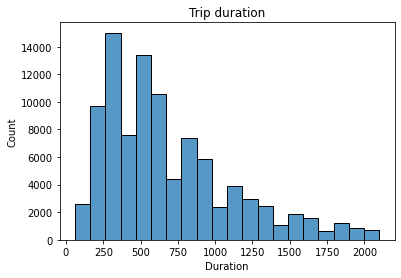

In [20]:
hist = sns.histplot(data=y_train, bins=20)
hist.set(xlabel="Duration")
hist.set_title("Trip duration")
plt.show()

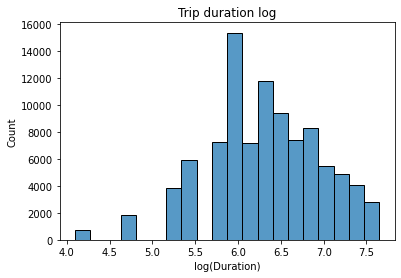

In [21]:
y_train = y_train.apply(np.log)
y_val = y_val.apply(np.log)
y_test = y_test.apply(np.log)

hist = sns.histplot(data=y_train, bins=20)
hist.set(xlabel="log(Duration)")
hist.set_title("Trip duration log")
plt.show()

In [22]:
normalizer_y = MinMaxScaler()
normalizer_y = normalizer_y.fit(y_train.to_numpy().reshape(-1, 1))
y_train = normalizer_y.transform(y_train.to_numpy().reshape(-1, 1)).squeeze()
y_val = normalizer_y.transform(y_val.to_numpy().reshape(-1, 1)).squeeze()
y_test = normalizer_y.transform(y_test.to_numpy().reshape(-1, 1)).squeeze()

## Model

The model has 5 linear layers with ReLU activation function

In [23]:
class Net(nn.Module):
    def __init__(self, n_feature, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feature, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, n_output),
        )

    def forward(self, x):
        return self.layers(x)

## Model Training

<code>USE_PRETRAINED_MODEL</code> should be set to <code>True</code> if you want to download and use a pretrained model. If you want to train your model, please set it to <code>False</code>.

In [24]:
USE_PRETRAINED_MODEL = True

In [25]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def fit():
    start = time.time()
    losses_train = []
    losses_val = []
    num_batches_train = (n - 1) // batch_size + 1
    num_batches_val = (X_val_t.shape[0] - 1) // batch_size + 1

    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        for i in range(num_batches_train):
            optimizer.zero_grad()
            random_indexes = random.sample(range(0, X_train_t.shape[0] - 1), batch_size)
            xb = X_train_t[random_indexes].float()
            yb = y_train_t[random_indexes].float().reshape(-1, 1)
            pred = net(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        for i in range(num_batches_val):
            start_i = i * batch_size
            end_i = start_i + batch_size
            xb = X_val_t[start_i:end_i].float()
            yb = y_val_t[start_i:end_i].float().reshape(-1, 1)
            pred = net(xb)
            loss = loss_func(pred, yb)
            epoch_val_loss += loss.item()

        epoch_train_loss /= num_batches_train
        epoch_val_loss /= num_batches_val
        losses_train.append(epoch_train_loss)
        losses_val.append(epoch_val_loss)
        print(
            "Epoch "
            + str(epoch)
            + " %s (%d %d%%) Train loss: %.4f Validation loss: %.4f"
            % (
                timeSince(start),
                epoch,
                epoch / epochs * 100,
                epoch_train_loss,
                epoch_val_loss,
            )
        )

    return losses_train, losses_val

In [26]:
X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t = map(
    torch.tensor,
    (X_train.to_numpy(), y_train, X_val.to_numpy(), y_val, X_test.to_numpy(), y_test),
)

if USE_PRETRAINED_MODEL:
    model_url = "https://actionengine-public.s3.us-east-2.amazonaws.com/model"
    model_path = "model"
    load_data(model_url, model_path)
    net = torch.load("model")
    net.eval()
else:
    net = Net(n_feature=16, n_output=1)  # define the network
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    loss_func = nn.MSELoss()  # this is for regression mean squared loss
    batch_size = 20
    n = X_train.shape[0]
    epochs = 100

    losses_train, losses_val = fit()
    print(
        "Min train loss: ", min(losses_train), " Min validation loss: ", min(losses_val)
    )

    torch.save(net, "model")
    # show loss graph
    loss_data = pd.DataFrame(
        {
            "Epochs": [j for j in range(0, epochs)],
            "Train loss": losses_train,
            "Validation loss": losses_val,
        }
    )

    sns.lineplot(
        x="Epochs", y="value", hue="variable", data=pd.melt(loss_data, ["Epochs"])
    ).set_title("Training process")

## Model Evaluation

### Metrics

[MSE](https://en.wikipedia.org/wiki/Mean_squared_error) and [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) metrics for normalized data

In [27]:
test_len = X_test_t.shape[0]
mse_metric = torch.nn.MSELoss()
mae_metric = torch.nn.L1Loss()
preds = []
mse = 0
mae = 0

for i in range(test_len):
    xb = X_test_t[i].float()
    yb = y_test_t[i].float().reshape(1)
    pred = net(xb)
    preds.append(pred.item())
    mse += mse_metric(pred, yb).item()
    mae += mae_metric(pred, yb).item()

mse /= test_len
mae /= test_len

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  0.05857407048629879
MAE:  0.19285388396538267


MAE and [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) metrics for original data

In [28]:
unnormalized_y = normalizer_y.inverse_transform(y_test.reshape(-1, 1))
y_exp = np.exp(unnormalized_y)

unnormalized_preds = normalizer_y.inverse_transform(np.array(preds).reshape(-1, 1))
preds_exp = np.exp(unnormalized_preds)

print("MAE: ", mean_absolute_error(preds_exp, y_exp))
print("MAPE: ", mean_absolute_percentage_error(preds_exp, y_exp))

MAE:  406.5988417651013
MAPE:  0.9196030527892463


The model makes mistakes at around 40%. For example, if ground truth value is 700, the model is likely to answer 980 or 420

### Comparison to Ground Truth Values

In [29]:
for i in random.sample(range(0, len(y_exp) - 1), 10):
    print("Real: ", y_exp[i], " Predicted: ", preds_exp[i])

Real:  [60.]  Predicted:  [488.20455068]
Real:  [1620.]  Predicted:  [247.505973]
Real:  [960.]  Predicted:  [744.83486835]
Real:  [480.]  Predicted:  [618.38780566]
Real:  [540.]  Predicted:  [758.17566408]
Real:  [1140.]  Predicted:  [738.92672752]
Real:  [120.]  Predicted:  [559.92803217]
Real:  [660.]  Predicted:  [426.57767477]
Real:  [420.]  Predicted:  [500.63716407]
Real:  [780.]  Predicted:  [386.17757061]


### Testing Using Synthetic Dataset

To imitate a real-world task a synthetic dataset is generated. It contains a row for each hour in a particular day for each station. The model should predict a duration of a trip, that starts from such station in such time.

Dataset generation and normalization.

In [30]:
d = {column_name: [] for column_name in X.columns}
columns_from_X = [
    "Starting Station ID",
    "Starting Station Latitude",
    "Starting Station Longitude",
    "Neighborhood Councils (Certified)",
    "Council Districts",
    "Zip Codes",
    "Precinct Boundaries",
    "Census Tracts",
]
columns_same = {
    "Passholder Type": "Monthly Pass",
    "Trip Route Category": "One Way",
    "Plan Duration": 30,
    "Year": 2017,
    "Month": 3,
    "Day": 22,
    "Minute": 0,
}
for i in range(118):  # there are 118 stations
    for hour in range(24):
        part_station = X[
            X["Starting Station Latitude"]
            == start_stations.iloc[i]["Starting Station Latitude"]
        ].reset_index(drop=True)
        part_station_0 = part_station.iloc[0]
        for column_name in columns_from_X:
            d[column_name].append(part_station_0[column_name])
        for column_name in columns_same:
            d[column_name].append(columns_same[column_name])
        d["Hour"].append(hour)

generated_ds = pd.DataFrame(d)
generated_ds_encoded = count_encoder.transform(generated_ds)
generated_ds_encoded[columns_to_normalize] = normalizer.transform(
    generated_ds_encoded[columns_to_normalize]
)
generated_ds

,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Plan Duration,Trip Route Category,Passholder Type,Neighborhood Councils (Certified),Council Districts,Zip Codes,Precinct Boundaries,Census Tracts,Year,Month,Day,Hour,Minute
0,4108.0,34.025890,-118.238243,30,One Way,Monthly Pass,0.0,0.0,0.0,1287.0,533.0,2017,3,22,0,0
1,4108.0,34.025890,-118.238243,30,One Way,Monthly Pass,0.0,0.0,0.0,1287.0,533.0,2017,3,22,1,0
2,4108.0,34.025890,-118.238243,30,One Way,Monthly Pass,0.0,0.0,0.0,1287.0,533.0,2017,3,22,2,0
3,4108.0,34.025890,-118.238243,30,One Way,Monthly Pass,0.0,0.0,0.0,1287.0,533.0,2017,3,22,3,0
4,4108.0,34.025890,-118.238243,30,One Way,Monthly Pass,0.0,0.0,0.0,1287.0,533.0,2017,3,22,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,3078.0,34.064282,-118.238940,30,One Way,Monthly Pass,28.0,11.0,22728.0,1050.0,546.0,2017,3,22,19,0
2828,3078.0,34.064282,-118.238940,30,One Way,Monthly Pass,28.0,11.0,22728.0,1050.0,546.0,2017,3,22,20,0
2829,3078.0,34.064282,-118.238940,30,One Way,Monthly Pass,28.0,11.0,22728.0,1050.0,546.0,2017,3,22,21,0
2830,3078.0,34.064282,-118.238940,30,One Way,Monthly Pass,28.0,11.0,22728.0,1050.0,546.0,2017,3,22,22,0


Make predictions and unnormalize them

In [31]:
tensor_generated = torch.tensor(generated_ds_encoded.to_numpy())
tensor_generated_len = tensor_generated.shape[0]

preds_for_gen_data = []

for i in range(tensor_generated_len):
    xb = tensor_generated[i].float()
    pred = net(xb)
    preds_for_gen_data.append(pred.item())

unnormalized_preds_for_gen_data = normalizer_y.inverse_transform(
    np.array(preds_for_gen_data).reshape(-1, 1)
)
preds_exp_for_gen_data = np.exp(unnormalized_preds_for_gen_data)

generated_ds_preds = generated_ds[
    ["Starting Station Latitude", "Starting Station Longitude", "Hour"]
].copy()
generated_ds_preds["Pred Duration"] = preds_exp_for_gen_data

dates = []
for hour_value in generated_ds_preds["Hour"]:
    dates.append(str(pd.to_datetime("2017-03-22 " + str(hour_value) + ":00:00")))

generated_ds_preds["Date"] = dates

generated_ds_preds

,Starting Station Latitude,Starting Station Longitude,Hour,Pred Duration,Date
0,34.025890,-118.238243,0,539.583347,2017-03-22 00:00:00
1,34.025890,-118.238243,1,548.735739,2017-03-22 01:00:00
2,34.025890,-118.238243,2,558.043374,2017-03-22 02:00:00
3,34.025890,-118.238243,3,567.508884,2017-03-22 03:00:00
4,34.025890,-118.238243,4,545.649975,2017-03-22 04:00:00
...,...,...,...,...,...
2827,34.064282,-118.238940,19,313.244931,2017-03-22 19:00:00
2828,34.064282,-118.238940,20,304.082308,2017-03-22 20:00:00
2829,34.064282,-118.238940,21,287.334123,2017-03-22 21:00:00
2830,34.064282,-118.238940,22,264.966079,2017-03-22 22:00:00


Points on a map represent starting stations location. The lighter a point, the longer a trip would start from it. There is also a time filter available. You can watch how trip duration estimation varies from time. 

In [ ]:
hourly_map = UnfoldedMap(height=800)
hourly_map

In [32]:
hourly_dataset_id = uuid4()
hourly_dataset_filter_id = uuid4()

hourly_map.add_dataset(
    {
        "uuid": hourly_dataset_id,
        "label": "Hourly duration dataset",
        "data": generated_ds_preds,
    },
    auto_create_layers=False,
)

hourly_map.set_filter(
    {
        "id": str(hourly_dataset_filter_id),
        "field": "Date",
        "type": "timeRange",
        "value": [1490140800000, 1490223600000],
    }
)

hourly_map.add_layer(
    {
        "id": "Hourly duration",
        "type": "point",
        "config": {
            "label": "Hourly duration",
            "data_id": hourly_dataset_id,
            "columns": {
                "lat": "Starting Station Latitude",
                "lng": "Starting Station Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "Pred Duration", "type": "float"},
            "visConfig": {"radius": 17},
        },
    }
)


hourly_map.set_view_state({"longitude": -118.25, "latitude": 34.024, "zoom": 12})

UnfoldedMap(height=800)